In [1]:
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

nz=101; nx=101; h=20

nt=500; dt=0.006
ntr=1

def read(filename,n=None):
    if n==None:
        nn=(nx,nz)
    else:
        nn=n
    return np.fromfile(filename,dtype='float32').reshape(nn).T

tmppath='/home/wzhou/'
if not os.path.exists(tmppath): tmppath='/home/zhouw/'
tmppath=tmppath+'tmp'
    
def read_su(filename):
    !sustrip < $filename > $tmppath outpar=outpar
    data=read(tmppath,n=(ntr,nt))
    !rm $tmppath
    return data

def imshow(data,perc=None,clip=None,clipmin=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def amp_spec(data):
    return abs(np.fft.rfft(data))

## FWD

rm: cannot remove 'rho1': No such file or directory
rm: cannot remove 'rho2': No such file or directory


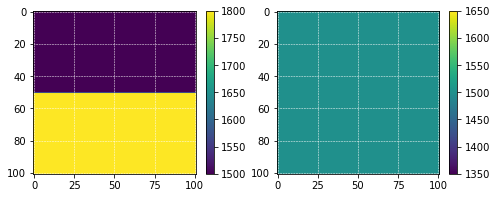

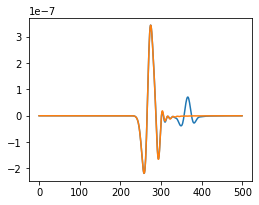

In [2]:
## with reflections
!makevel nz=51 nx=$nx v000=1500 > vp1
!makevel nz=50 nx=$nx v000=1800 > vp2
!cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
!rm vp1 vp2 rho1 rho2 tmp*

!makevel nz=1 nx=$nx v000=100 > topo
#!makevel nz=1 nx=$nx v000=400 > topo

## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('model'))

!../../exe/FWD setup.in > out_fwd

!rm -r results_fwd; mv results  results_fwd

## w/o reflections
!makevel nz=$nz nx=$nx v000=1500 > model

!../../exe/FWD setup.in > out_fwd_norefl

!rm -r results_fwd_norefl; mv results  results_fwd_norefl

## plot
plt.subplot(1,2,2); imshow(read('model'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_fwd_norefl/dsyn_Shot0001.su'))

**Test PFEI with ricker-wavelet data (NOT envelope data)** 

## PFEI build tilD
### PFEI gradient for tilD

In [3]:
# # with reflections
# !makevel nz=51 nx=$nx v000=1500 > vp1
# !makevel nz=50 nx=$nx v000=1800 > vp2
# !cat vp1  vp2  > tmp1 && transp < tmp1 n1=$nx > model
# !rm vp1 vp2 rho1 rho2 tmp*

# w/o reflections
!makevel nz=$nz nx=$nx v000=1500 > model

!cp setup.in setup_grad.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_grad.in

!../../exe/PFEI setup_grad.in  > out_grad
!rm -r results_grad; mv results results_grad

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


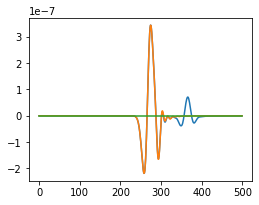

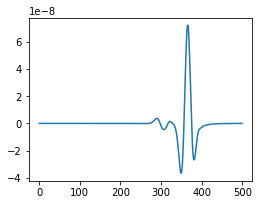

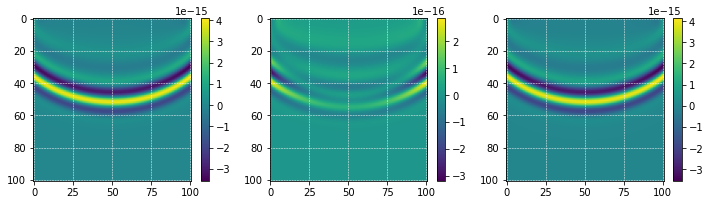

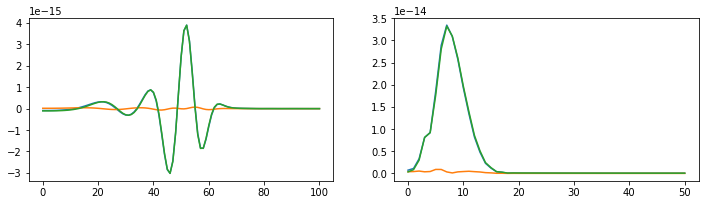

In [4]:
plt.figure(figsize=(4,3))
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.plot(read_su('results_grad/RdE_Shot0001.su'))

plt.figure(figsize=(4,3))
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1);tmp1=read('results_grad/gtilD_dt2'); imshow(tmp1)
plt.subplot(1,3,2);tmp2=1800**2*read('results_grad/gtilD_nab2'); imshow(tmp2)
plt.subplot(1,3,3);imshow(tmp1-tmp2)

plt.figure(figsize=(12,3))
plt.subplot(1,2,1); plt.plot(tmp1[:,50]); plt.plot(tmp2[:,50]); plt.plot(tmp1[:,50]-tmp2[:,50])
plt.subplot(1,2,2); plt.plot(amp_spec(tmp1[:,50])); plt.plot(amp_spec(tmp2[:,50])); plt.plot(amp_spec(tmp1[:,50]-tmp2[:,50]))

# plt.figure(figsize=(12,3))
# plt.subplot(1,3,1);imshow(signal.medfilt2d(tmp1))
# plt.subplot(1,3,2);imshow(signal.medfilt2d(tmp2))
# plt.subplot(1,3,3);imshow(signal.medfilt2d(tmp1)-signal.medfilt2d(tmp2))

### GradientTest

In [38]:
# w/o reflections
!makevel nz=$nz nx=$nx v000=1500 > model

!make

!cp setup.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "JOB   'build tilD'" >> setup_test.in
!echo "ALPHAS '-1e-2 -1e-3 -1e-4 1e-4 1e-3 1e-2' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

In [40]:
# w/o reflections
!makevel nz=$nz nx=$nx v000=1500 > model

!make

!cp setup.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "JOB   'build tilD'" >> setup_test.in
# !echo "DESCENT_DIR   'stack'" >> setup_test.in
#!echo "PRECO   'none'" >> setup_test.in
!echo "ALPHAS '4e-3' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

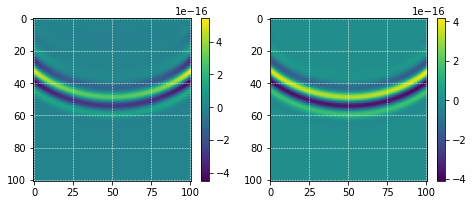

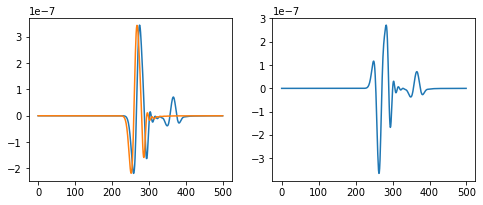

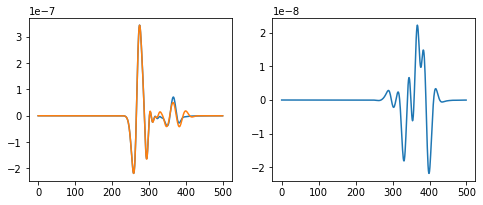

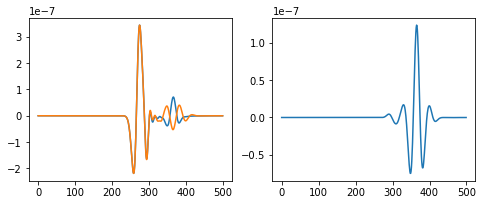

In [41]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
imshow(read('results/qp0%g'))
plt.subplot(1,3,2)
imshow(read('results/qp0%pg'))
# plt.subplot(1,3,3)
# imshow(read('results/curr%d'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su')-read_su('results_grad/RE0_Shot0001.su'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')+read_su('results/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results/dadj_Shot0001.su'))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su')-read_su('results/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su')-(read_su('results/RE0_Shot0001.su')-read_su('results/RdE_Shot0001.su')))


## PFEI update vp2
### PFEI gradient for vp2

In [52]:
# with nonzero tilD
!makevel nz=$nz nx=$nx v000=1550 > vp
#from PFEI gradient test w/ ALPHAS 1e-3
#cp results/pert%x prior_tilD_scaled
!farith < prior_tilD_scaled op=scale scale=10 | farith op=bias bias=-5 > tilD
!cat vp tilD > model

!cp setup-vp2.in setup_grad.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_grad.in
#!echo "WEIGHTING    polygon" >> setup_grad.in
#!echo "FILE_WEIGHT_POLYGON    wei_notEnv" >> setup_grad.in

!../../exe/PFEI setup_grad.in  > out_grad
!rm -r results_grad; mv results results_grad

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


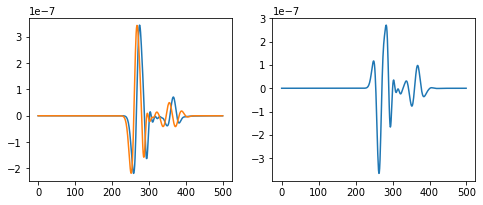

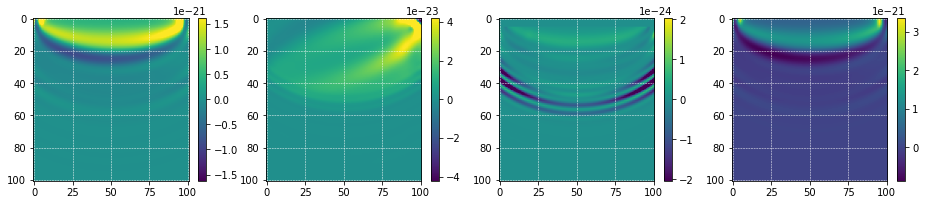

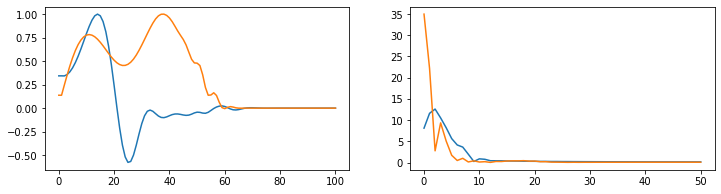

In [53]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su')+read_su('results_grad/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

tilD=read('tilD')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1);tmp1=read('results_grad/gvp2_F1_star_E0'); imshow(tmp1,perc=99)
plt.subplot(1,4,2);tmp2=read('results_grad/gvp2_F2_star_dE'); imshow(tmp2,perc=99)
plt.subplot(1,4,3);tmp3=tilD*read('results_grad/gvp2_F2_star_E0'); imshow(tmp3,perc=99)
plt.subplot(1,4,4);imshow(tmp1+tmp2-tmp3)

plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
tmp1=tmp1[:,50]; tmp1=tmp1/np.amax(np.abs(tmp1)); plt.plot(tmp1)
tmp2=tmp2[:,50]; tmp2=tmp2/np.amax(np.abs(tmp2)); plt.plot(tmp2)

plt.subplot(1,2,2)
plt.plot(amp_spec(tmp1))
plt.plot(amp_spec(tmp2))

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


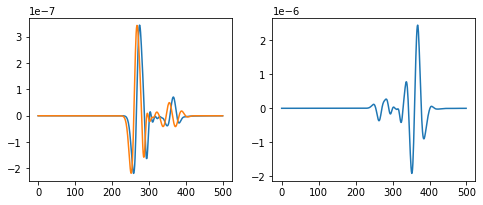

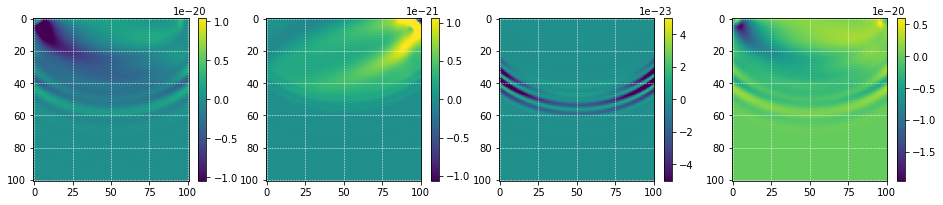

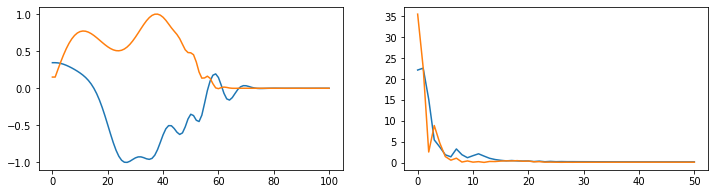

In [54]:
# with nonzero tilD
!makevel nz=$nz nx=$nx v000=1550 > vp
#from PFEI gradient test w/ ALPHAS 1e-3
#!cp results/pert%x prior_tilD_scaled
!farith < prior_tilD_scaled op=scale scale=10 | farith op=bias bias=-5 > tilD
!cat vp tilD > model

!cp setup-vp2.in setup_grad.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_grad.in
!echo "WEIGHTING    polygon" >> setup_grad.in
!echo "FILE_WEIGHT_POLYGON    wei_notEnv" >> setup_grad.in

!../../exe/PFEI setup_grad.in  > out_grad
!rm -r results_grad; mv results results_grad

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su')+read_su('results_grad/RdE_Shot0001.su'))
plt.subplot(1,2,2)
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

tilD=read('tilD')

plt.figure(figsize=(16,3))
plt.subplot(1,4,1);tmp1=read('results_grad/gvp2_F1_star_E0'); imshow(tmp1,perc=99)
plt.subplot(1,4,2);tmp2=read('results_grad/gvp2_F2_star_dE'); imshow(tmp2,perc=99)
plt.subplot(1,4,3);tmp3=tilD*read('results_grad/gvp2_F2_star_E0'); imshow(tmp3,perc=99)
plt.subplot(1,4,4);imshow(tmp1+tmp2-tmp3)

plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
tmp1=tmp1[:,50]; tmp1=tmp1/np.amax(np.abs(tmp1)); plt.plot(tmp1)
tmp2=tmp2[:,50]; tmp2=tmp2/np.amax(np.abs(tmp2)); plt.plot(tmp2)

plt.subplot(1,2,2)
plt.plot(amp_spec(tmp1))
plt.plot(amp_spec(tmp2))

### Gradient test

In [78]:
!make

!cp setup-vp2.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
#!echo "WEIGHTING    polygon" >> setup_test.in
#!echo "FILE_WEIGHT_POLYGON    wei_notEnv" >> setup_test.in
!echo "ALPHAS '-1e4 1e4 1e5 5e5 1e6' " >> setup_test.in
#!echo "ALPHAS '1e5' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

In [79]:
!make

!cp setup-vp2.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
#!echo "WEIGHTING    polygon" >> setup_test.in
#!echo "FILE_WEIGHT_POLYGON    wei_notEnv" >> setup_test.in
#!echo "ALPHAS '-1e4 -1e3 1e-3 1e4' " >> setup_test.in
!echo "ALPHAS '1e5' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

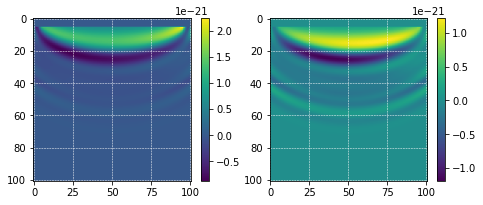

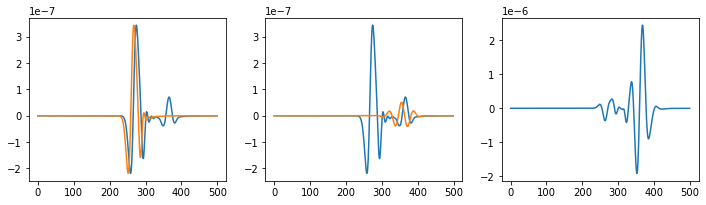

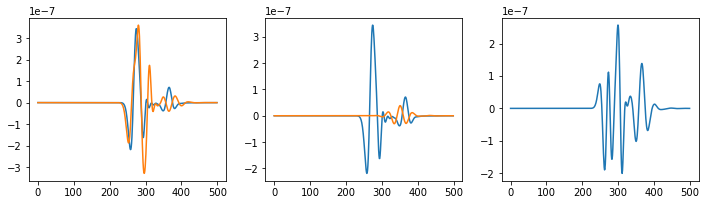

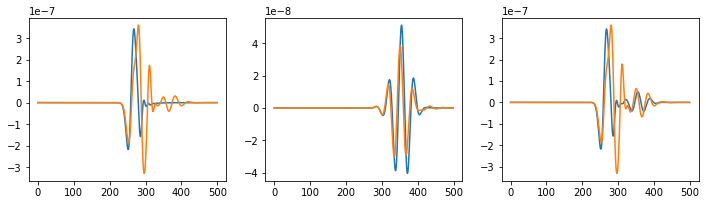

In [80]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
imshow(read('results/qp0%g'))
plt.subplot(1,3,2)
imshow(read('results/qp0%pg'))
# plt.subplot(1,3,3)
# imshow(read('results/curr%d'))

#before
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.subplot(1,3,2)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RdE_Shot0001.su'))
plt.subplot(1,3,3)
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

#after
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su'))
plt.subplot(1,3,2)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results/RdE_Shot0001.su'))
plt.subplot(1,3,3)
plt.plot(read_su('results/dadj_Shot0001.su'))

#syn's before vs after
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.plot(read_su(     'results/RE0_Shot0001.su'))
plt.subplot(1,3,2)
plt.plot(read_su('results_grad/RdE_Shot0001.su'))
plt.plot(read_su(     'results/RdE_Shot0001.su'))
plt.subplot(1,3,3)
plt.plot(read_su('results_grad/RE0_Shot0001.su')+read_su('results_grad/RdE_Shot0001.su'))
plt.plot(read_su(     'results/RE0_Shot0001.su')+read_su(     'results/RdE_Shot0001.su'))

In [83]:
!make

!cp setup-vp2.in setup_test.in
!echo "FILE_DATA_PREFIX    'results_fwd/dsyn_Shot'" >> setup_test.in
!echo "SMOOTHING    'Laplacian'" >> setup_test.in
!echo "LAP_FRAC     '0.5 0.5 0.5'" >> setup_test.in
#!echo "WEIGHTING    polygon" >> setup_test.in
#!echo "FILE_WEIGHT_POLYGON    wei_notEnv" >> setup_test.in
#!echo "ALPHAS '-1e4 -1e3 1e-3 1e4' " >> setup_test.in
!echo "ALPHAS '1e5' " >> setup_test.in

!rm -r results
!../../exe/GradientTest  setup_test.in > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

#System
(cd ../../Modules/System; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/System'
#Etc
(cd ../../Modules/Etc; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Etc'
#Signal
(cd ../../Modules/Signal; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Signal'
#Modeling
(cd ../../Modules/Modeling; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'

make[1]: Leaving directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Modeling'
#Kernel
(cd ../../Modules/Kernel; make App=FWI)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/Kernel'
m_parametrizer_vp2-tilD.f90 m_querypoint.f90 m_weighter.f90 m_preconditioner.f90 m_fo

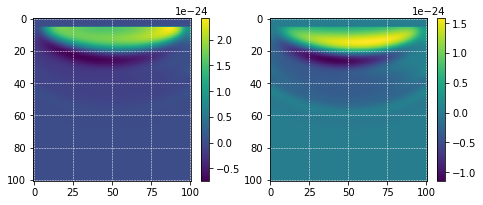

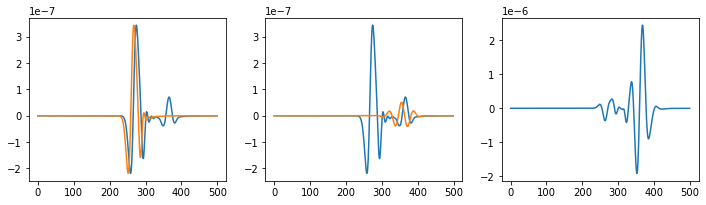

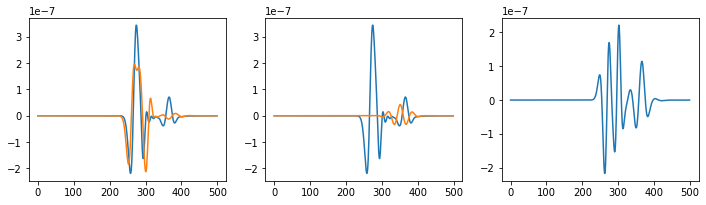

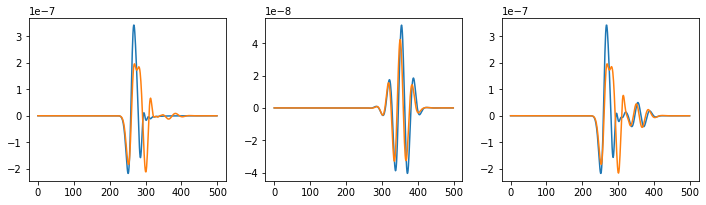

In [84]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
imshow(read('results/qp0%g'))
plt.subplot(1,3,2)
imshow(read('results/qp0%pg'))
# plt.subplot(1,3,3)
# imshow(read('results/curr%d'))

#before
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.subplot(1,3,2)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results_grad/RdE_Shot0001.su'))
plt.subplot(1,3,3)
plt.plot(read_su('results_grad/dadj_Shot0001.su'))

#after
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results/RE0_Shot0001.su'))
plt.subplot(1,3,2)
plt.plot(read_su('results_fwd/dsyn_Shot0001.su'))
plt.plot(read_su('results/RdE_Shot0001.su'))
plt.subplot(1,3,3)
plt.plot(read_su('results/dadj_Shot0001.su'))

#syn's before vs after
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(read_su('results_grad/RE0_Shot0001.su'))
plt.plot(read_su(     'results/RE0_Shot0001.su'))
plt.subplot(1,3,2)
plt.plot(read_su('results_grad/RdE_Shot0001.su'))
plt.plot(read_su(     'results/RdE_Shot0001.su'))
plt.subplot(1,3,3)
plt.plot(read_su('results_grad/RE0_Shot0001.su')+read_su('results_grad/RdE_Shot0001.su'))
plt.plot(read_su(     'results/RE0_Shot0001.su')+read_su(     'results/RdE_Shot0001.su'))